In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sp_inference import logging, processes, model
from sp_inference.postprocessing import visualization as viz, data_types as dt

In [31]:
logSettings = {
    "output_directory":      "03_example_transient",
    "verbose":               True,
    "print_interval":        1
}

dataSettings = {
    "process_type":          "Dr31Di20Process",
    "drift_parameters":      [2, 3],
    "diffusion_parameters":  [1, 2],
    "standard_deviation":    0.01,
    "rng_seed":              0,
    "num_domain_points":     50,
    "num_time_points":       10,
    "domain_bounds":         [-2.5, 2.5],
    "time_bounds":           [0.1, 1]
}

modelSettings = {
    "params_to_infer":       "all",
    "model_type":            "fokker_planck",
    "is_stationary":         False
}

priorSettings = {
    "mean_function":         ["-4*x", 6],
    "variance":              ["1 + (4*x)**2", "1 + (2*x)**2"],
    "correlation_length":    [2, 2],
    "robin_bc":              [True, True],
    "robin_bc_const":        [5, 5]
}

feSettings = {
    "num_mesh_points":       500,
    "boundary_locations":    [-5, 5],
    "boundary_values":       [0, 0],
    "element_degrees":       [1, 1]
}

transientSettings = {
    "start_time":            0.1,
    "end_time":              1.1,
    "time_step_size":        0.025,
    "initial_condition":     "2/sqrt(2*pi) * exp(-0.5*x**2)"
}

solverSettings = {
    "rel_tolerance":         1e-6,
    "abs_tolerance":         1e-12,
    "max_iter":              10,
    "GN_iter":               5,
    "c_armijo":              1e-4,
    "max_backtracking_iter": 10
}

hessianSettings = {
    "num_eigvals":           60,
    "num_oversampling":      10
}

visualizationSettings = {
    "show":                  True,
    "time_points":           [0.1, 1.0]
}

In [32]:
try:
    os.system('rm -r ' + logSettings["output_directory"])
except:
    pass

logger = logging.Logger(logSettings["verbose"],
                        logSettings["output_directory"],
                        logSettings["print_interval"])

In [33]:
randGenerator = np.random.default_rng(dataSettings["rng_seed"])
randLocs = randGenerator.uniform(*dataSettings["domain_bounds"], dataSettings["num_domain_points"])
randTimes = np.linspace(*dataSettings["time_bounds"], dataSettings["num_time_points"])

dataSettings["domain_points"] = randLocs
dataSettings["time_points"] = randTimes
dataSettings["fem_settings"] = feSettings
dataSettings["solver_settings"] = transientSettings

processType = processes.get_process(dataSettings["process_type"])
process = processType(dataSettings["drift_parameters"],
                      dataSettings["diffusion_parameters"],
                      logger)

forwardNoisy, forwardExact = process.generate_data(modelSettings["model_type"],
                                                   modelSettings["is_stationary"],
                                                   dataSettings)

exactDrift = process.compute_drift(randLocs)
exactDiffusion = process.compute_squared_diffusion(randLocs)
exactParamValues = [exactDrift, exactDiffusion]

misFitSettings = {
    "data_locations": randLocs,
    "data_times": randTimes,
    "data_values": forwardNoisy,
    "data_var": dataSettings["standard_deviation"]**2
}

================== Invoke Dr31Di20Process ==================
 
Drift Coefficient(s): [2, 3] 
Diffusion Coefficient(s): [1, 2] 

Generate transient FPE data:       Successful 



In [34]:
inferenceModel = model.SDEInferenceModel(modelSettings,
                                         priorSettings,
                                         feSettings,
                                         misFitSettings,
                                         transientSettings,
                                         logger)

priorMeanData, priorVarianceData, priorForwardData = inferenceModel.get_prior_info("Randomized")
mapMeanData, mapVarianceData, mapForwardData, hessEigVals \
    = inferenceModel.compute_gr_posterior(solverSettings, hessianSettings)

================== Invoke Inference Model ==================
 
Construct PDE Problem:             Successful 

Construct Prior:                   Successful 

Construct Misfit:                  Successful 

 
=============== Conduct Linearized Inference ===============
 
Solve for MAP: 

It  cg_it cost            misfit          reg             (g,dm)          ||g||L2        alpha          tolcg         
  1   1    3.898447e+04    3.898328e+04    1.195569e+00   -1.219054e+05   9.584376e+04   1.000000e+00   5.000000e-01
  2   1    1.830380e+04    1.830314e+04    6.617930e-01   -4.785579e+04   3.780769e+04   1.000000e+00   5.000000e-01
  3   3    2.663094e+03    2.659545e+03    3.548581e+00   -3.373058e+04   3.418895e+04   1.000000e+00   5.000000e-01
  4   3    1.683858e+03    1.680764e+03    3.093692e+00   -2.030302e+03   1.474839e+04   1.000000e+00   3.922748e-01
  5  11    7.238310e+02    7.195381e+02    4.292853e+00   -1.969764e+03   8.160610e+03   1.000000e+00   2.917960e-01
  6  18

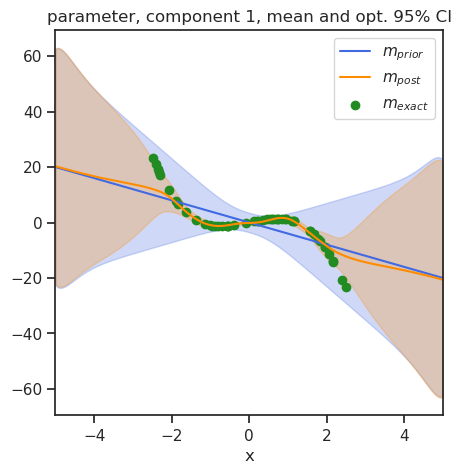

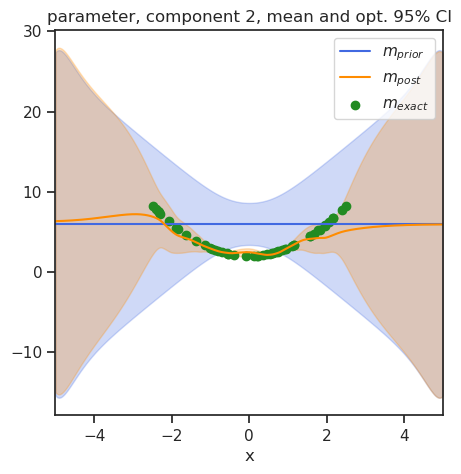

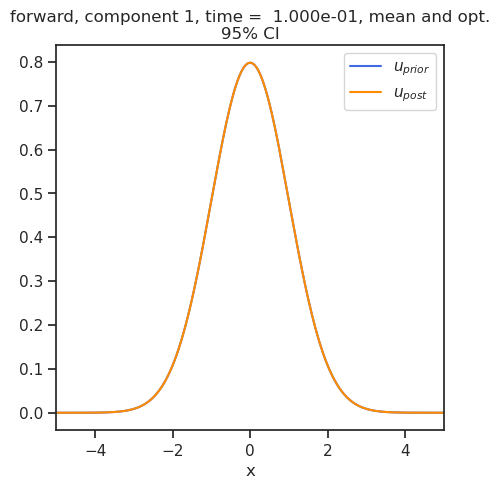

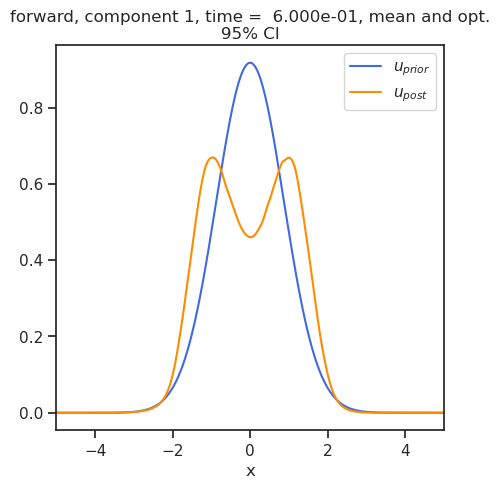

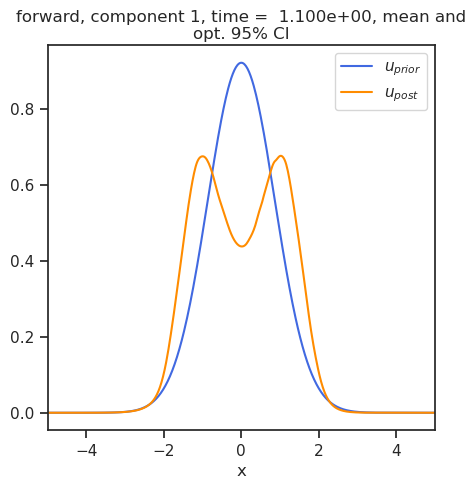

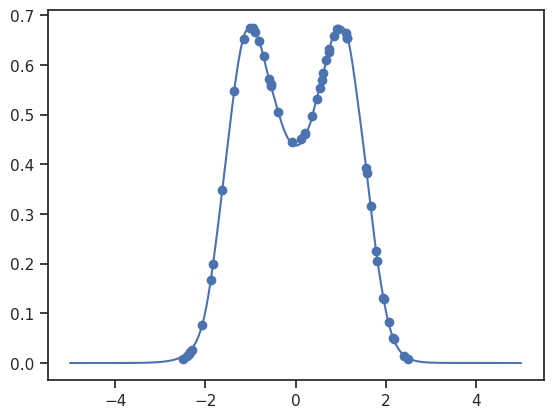

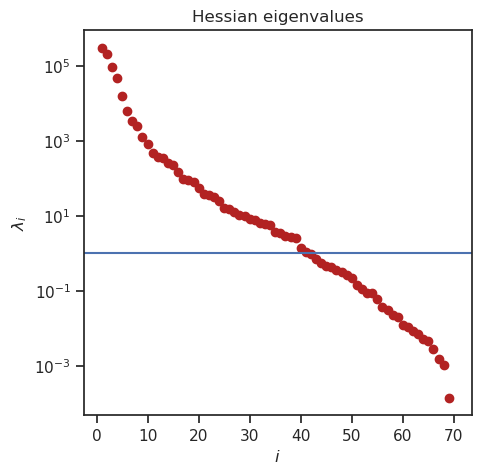

In [35]:
forward_data = np.split(forwardNoisy, forwardNoisy.shape[0])
forward_exact = np.split(forwardExact, forwardExact.shape[0])
prior_mean_list = np.split(priorMeanData[1], priorMeanData[1].shape[1], axis=1)
prior_var_list = np.split(priorVarianceData[1], priorVarianceData[1].shape[1], axis=1)
map_mean_list = np.split(mapMeanData[1], mapMeanData[1].shape[1], axis=1)
map_var_list = np.split(mapVarianceData[1], mapVarianceData[1].shape[1], axis=1)
prior_forward_list = np.split(priorForwardData[2], priorForwardData[2].shape[0])
map_forward_list = np.split(mapForwardData[2], mapForwardData[2].shape[0])

parameter_domain = dt.Grid1D(priorMeanData[0])
forward_domain = dt.Grid1D(priorForwardData[0])
data_domain = dt.Grid1D(randLocs)
forward_times = priorForwardData[1]
data_times = randTimes

prior_mean_components = dt.StationaryFieldComponent.from_iterable(parameter_domain, prior_mean_list)
prior_var_components = dt.StationaryFieldComponent.from_iterable(parameter_domain, prior_var_list)
prior_forward_component = dt.TimeDependentFieldComponent(forward_domain,
                                                         forward_times,
                                                         prior_forward_list)
map_mean_components = dt.StationaryFieldComponent.from_iterable(parameter_domain, map_mean_list)
map_var_components = dt.StationaryFieldComponent.from_iterable(parameter_domain, map_var_list)
map_forward_component = dt.TimeDependentFieldComponent(forward_domain,
                                                       forward_times,
                                                       map_forward_list)
exact_param_component = dt.StationaryFieldComponent.from_iterable(data_domain, exactParamValues)
data_component = dt.TimeDependentFieldComponent(data_domain, data_times, forward_data)

prior_mean_field = dt.StationaryField(prior_mean_components)
prior_var_field = dt.StationaryField(prior_var_components)
prior_forward_field = dt.TimeDependentField(prior_forward_component)
map_mean_field = dt.StationaryField(map_mean_components)
map_var_field = dt.StationaryField(map_var_components)
map_forward_field = dt.TimeDependentField(map_forward_component)
exact_param_field = dt.StationaryField(exact_param_component)
data_field = dt.TimeDependentField(data_component)

prior_param_data = dt.InferenceData(label=r'$m_{prior}$',
                                    field=prior_mean_field,
                                    variance_field=prior_var_field)
posterior_param_data = dt.InferenceData(label=r'$m_{post}$',
                                        field=map_mean_field,
                                        variance_field=map_var_field)
exact_param_data = dt.InferenceData(label=r'$m_{exact}$',
                                    field=exact_param_field,
                                    is_point_data=True)
prior_forward_data = dt.InferenceData(label=r'$u_{prior}$',
                                      field=prior_forward_field)
posterior_forward_data = dt.InferenceData(label=r'$u_{post}$',
                                          field=map_forward_field)
point_data = dt.InferenceData(label=r'$y$',
                              field=data_field,
                              is_point_data=True)

plt.close('all')
results_dir = os.path.join(logSettings["output_directory"], "visualization")
os.makedirs(results_dir, exist_ok=True)
visualizer = viz.Visualizer()
visualizer.plot_inference_data(prior_param_data,
                               posterior_param_data,
                               exact_param_data,
                               path_name=os.path.join(results_dir,"parameter"))
visualizer.plot_inference_data(prior_forward_data,
                               posterior_forward_data,
                               path_name=os.path.join(results_dir,"forward"))

_, ax = plt.subplots()
ax.scatter(randLocs, forward_exact[-1])
ax.plot(priorForwardData[0], map_forward_list[-1])

viz.plot_hessian_data(hessEigVals, path_name=results_dir)